In [1]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os,sys
import urllib.request
from astropy.table import QTable
import astropy.units as u
from astropy.io import fits
import csv
import yaml
import pickle as pk
%matplotlib inline

In [21]:
def s18dStack(ras, decs, data, width = 20., weight = False):
        stack = 0
        divisor = 0
        num = 0
        for i in range(len(ras)):
                path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'
                tileName = tileFinder(ras[i], decs[i], data)
                #print(ras[i], decs[i])

                #print(tileName)
                
                if tileName is None: continue
                    
                tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
                stamp = reproject.postage_stamp(tile, ras[i], decs[i], width, 0.5)
                if weight:
                    rms = fits.open('/scratch/r/rbond/jorlo/S18d_202006/selFn/RMSMap_Arnaud_M2e14_z0p4.fits')
                    #print(tileName)
                    for j in range(1,500):
                        if rms[j].header['EXTNAME'] == tileName:
                            break
                    #print(j)
                    
                    rmsmap = rms[j].data
                    #print(ras[i], decs[i])

                    coords = np.deg2rad(np.array((decs[i],ras[i])))
                    ypix,xpix = enmap.sky2pix(tile.shape,tile.wcs,coords)

                    weight = rmsmap[int(ypix),int(xpix)]**2
                    #print(rmsmap[int(ypix),int(xpix)])
                    
                    if weight < 10**-20:
                        continue
                    
                    try: 
                        stack += stamp[0]/weight
                    except:
                        print(tileName)
                        print(tile)
                        print(stamp)
                    num += 1
                    divisor += 1/weight

                else:
                    try: 
                        stack += stamp[0]
                    except:
                        print(tileName)
                        print(tile)
                        print(stamp)

                    divisor += 1
                    num += 1

        
        try:
            stack /= divisor
        except: 
            print("Error: no items in stack")
            return None, None
        print("Number in stack: {}".format(num))
        return stack, num

In [3]:
def s18dStacker(catalog, r_low, r_high, data, remove_act = True):
    ra = catalog[1].data['RADeg']
    dec = catalog[1].data['decDeg']
    ra, dec = np.array(ra), np.array(dec)
    rich = catalog[1].data['Rich']

    act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_z_independent_matches.fits')
    in_act = act[1].data['MADCOWSUnion_name']
    
    names = catalog[1].data['name']
    if remove_act:
        flags = [True]*len(ra)

        for i, name in enumerate(names):
            if name in in_act:
                flags[i] = False

        print("Number before confirmed removal: {}".format(len(ra)))
        ra = ra[flags]
        dec = dec[flags]
        rich = rich[flags]
        print("Number after confirmed removal: {}".format(len(ra)))

    print("Number above cut: {}".format(len(ra)))    
        
    cut = np.where((r_low<np.array(rich)) & (np.array(rich)<=r_high))[0]
    
    cut_ra, cut_dec = ra[cut], dec[cut]
    
    stack, num = s18dStack(cut_ra, cut_dec, data)
    print(num)
    
    if type(stack) == type(None):
        print("Error: No objects in stack")
        return None, None
    out, cen, cen_d, out_d = 0,0,0,0

    for i in range(len(stack[0])):
        for j in range(len(stack[0])):
            if (18<i<22) & (18<j<22):
                cen += stack[i][j]
                cen_d += 1
            else:
                out += stack[i][j]
                out_d += 1

    plot = plt.imshow(stack, extent = [-20,20,-20,20])
    plt.scatter(0,0, marker = '+', color = 'r')
    plt.colorbar(plot, format='%.0e')
    plt.title("ACT S18 dStack on MaDCoWS w/ {}=>Richness>{}\n Total in stack: {}".format(r_high, r_low, num))
    plt.savefig("./plots/mdcw_cut_rich_{}_{}_stack_s18d_y.png".format(r_low,r_high))
    plt.show()
    plt.close()
    
    enmap.write_map('./stacks/mdcw_cut_rich_{}_{}_stack_s18d_y.fits'.format(r_low,r_high), stack)
    
    return cen/cen_d, out/out_d

In [4]:
with open('/scratch/r/rbond/jorlo/S18d_202006/selFn/tileDefinitions.yml') as f:
    
    s18d = yaml.load(f)
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
def tileFinder(ra, dec, data):
    #Given an RA and Dec in deg, find the S18d tile containing that RA and Dec
    for i, tile in enumerate(data):
        box = tile['RADecSection']
        if box[0] >= box[1]:
            if (360 >= ra >= box[0] or 0 <= ra <box[1]) and box[2]<=dec<= box[3]:
                return tile['tileName']
        if box[0]<=ra<=box[1] and box[2]<=dec<= box[3]:
            return tile['tileName']
    return None

        

In [6]:
def s18dStamp(ra, dec, data, name, width = 0.5, write = True):
    #Find tile corresponding to RA, Dec
    path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'
    tileName = tileFinder(ra, dec, data)
    if tileName == None: return None
    tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
    
    
    stamp = reproject.postage_stamp(tile, ra, dec, width*60, 0.5)
    if write:
        #tempdec, tempra = np.deg2rad([dec, ra])
        #tempwid = np.deg2rad(width)
        #box = [[tempdec-tempwid,tempra-tempwid],[tempdec+tempwid,tempra+tempwid]]
 
        #stampgeo = tile.submap(box)
        
        #box = np.array([[ra-width/2,dec-width/2],[ra+width/2,dec+width/2]]) * utils.degree
        #shape, wcs = enmap.geometry(pos=box,res=0.5 * utils.arcmin,proj='car')
        #print(shape)
        #print(stampgeo.wcs)
        #print(stamp.wcs)
        #stamp.wcs = wcs
        #print(stamp.wcs)
        #print(stamp[0].shape)
        #plt.imshow(stamp[0])
        #plt.show()
        #Return map
        stamp.wcs.wcs.crval = [ra,dec]
        #plot = enplot.plot(stamp,mask=0)
        #enplot.show(plot)
        enmap.write_map('./for_tony/{}.fits'.format(name), stamp)
    return stamp


In [7]:
def getFlags(ra, dec, data):
    #Returns indeces of ra, dec that are inside a certain data 
    flags = []
    for i in range(len(ra)):
        if tileFinder(ra[i], dec[i], data) != None:
            flags.append(i)
    return flags

In [8]:
def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

In [9]:
def binmap(map2d, x, y, rbin):

    '''Bin a 2d map into a 1d symmteric radial profile (i.e. for B_l or radial profile)'''
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2+Y**2)
    d = np.digitize(R.flatten(), rbin)
    rbin1d = np.zeros(len(rbin))
    bin1d = np.zeros(len(rbin))
    binvar = np.zeros(len(rbin))
    binerr = np.zeros(len(rbin))
    for i in range (len(rbin)):
        rbin1d[i] = np.mean(R.flatten()[d==i+1])
        bin1d[i] = np.mean(map2d.flatten()[d==i+1])
        binvar[i] = np.var(map2d.flatten()[d==i+1])
        binerr[i] = np.sqrt(np.var(map2d.flatten()[d==i]) / len(map2d.flatten()[d==i+1]))
    return  rbin1d, bin1d, binvar, binerr

In [25]:
def offsetSim(ras, decs, name, width = 1.0):
    bootstraps = {'act_rs':[], 'act_bin_data':[]}

    xspline = np.linspace(-10, 10, 40)
    yspline = xspline
    rbin = np.linspace(0, np.sqrt(2)*max(xspline), 20)
    
    for j in range(50):
        flags = np.random.randint(len(ras), size = len(ras))

        ras_temp = ras[flags]
        decs_temp = decs[flags]
        
        for i in range(len(ras_temp)):
            ras_temp[i] = ras_temp[i] + np.random.normal(scale = (width)/60)
            decs_temp[i] = decs_temp[i] + np.random.normal(scale = np.sqrt(width)/60)
        
        stack_act, stack_num_act = s18dStack(ras_temp, decs_temp, s18d, weight = True)
        act_r_jk, act_bin_data_jk, c, d = binmap(stack_act,xspline,yspline,rbin)

        bootstraps['act_rs'].append(act_r_jk)
        bootstraps['act_bin_data'].append(act_bin_data_jk)
        print(j)
        
        pk.dump(bootstraps, open(name, "wb" ))
    return bootstraps

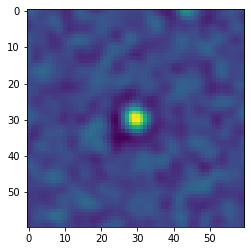

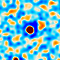

29.5,29.5


In [103]:
ra, dec = 5.55130626, -0.6048555
name = 'ACT-CL J0022.2-0036'
test= s18dStamp(ra, dec, s18d, name.replace(' ', '_'))#, write = True)

#test = enmap.read_map('./for_tony/150_ACT-CL_J2012.4-5649.fits')

plt.imshow(test[0])
plt.show()

plot = enplot.plot(test,mask=0)
enplot.show(plot)

coords = np.deg2rad(np.array((dec,ra)))
xpix,ypix = enmap.sky2pix(test.shape,test.wcs,coords)
print('{},{}'.format(xpix,ypix))

# Stacking all MDCW clusters less ACT Clusters

Number before confirmed removal: 2839
Number after confirmed removal: 2743
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 1476
2.86974357497e-06
-9.79883957461e-09


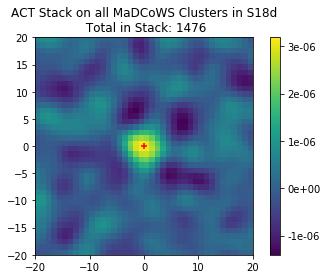

In [9]:
#Try stacking MDCW clusters on S18d

mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

mdcw_ra = mdcw_catalog[1].data['RADeg']
mdcw_dec =mdcw_catalog[1].data['decDeg']
mdcw_ra, mdcw_dec = np.array(mdcw_ra), np.array(mdcw_dec)
mdcw_rich = mdcw_catalog[1].data['Rich']

act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_z_independent_matches.fits')
in_act = act[1].data['MADCOWSUnion_name']


names = mdcw_catalog[1].data['name']

flags = [True]*len(mdcw_ra)

for i, name in enumerate(names):
    #print(name)
    if name in in_act:
        #print(i)
        flags[i] = False

print("Number before confirmed removal: {}".format(len(mdcw_ra)))
mdcw_ra = mdcw_ra[flags]
mdcw_dec = mdcw_dec[flags]
mdcw_rich = mdcw_rich[flags]
print("Number after confirmed removal: {}".format(len(mdcw_ra)))

s18d_stack, stack_num = s18dStack(mdcw_ra, mdcw_dec, s18d)

out, cen, cen_d, out_d = 0,0,0,0

for i in range(len(s18d_stack[0])):
    for j in range(len(s18d_stack[0])):
        if (18<i<22) & (18<j<22):
            cen += s18d_stack[i][j]
            cen_d += 1
        else:
            out += s18d_stack[i][j]
            out_d += 1
print(cen/cen_d)
print(out/out_d)


plot = plt.imshow(s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title("ACT Stack on all MaDCoWS Clusters in S18d\n Total in Stack: {}".format(stack_num))
plt.savefig("mdcw_stack_s18d_y.png")
plt.show()
plt.close()

/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


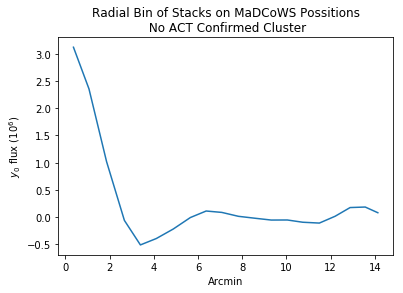

In [16]:
xspline = np.linspace(-10, 10, 40)
yspline = xspline

rbin = np.linspace(0, np.sqrt(2)*max(xspline), 20)


r, bin_data, c, d = binmap(s18d_stack,xspline,yspline,rbin)

plt.plot(r, bin_data*10**6)
plt.title('Radial Bin of Stacks on MaDCoWS Possitions\n No ACT Confirmed Cluster')
plt.xlabel('Arcmin')
plt.ylabel('$y_0$ flux ($10^6$)')
plt.savefig('mdcws_radial_bin.pdf')
plt.show()

# Stacking in bins of 10 richness, ACT clusters removed

Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 28
28


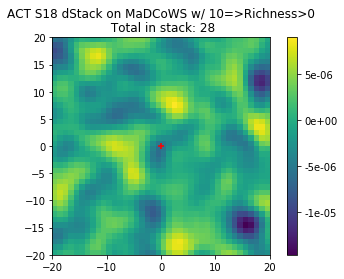

For richness bin 0 to 10 cen/cen_d = 7.965433740571284e-07, out/out_d = -1.0124021479041478e-07, s/n = -7.86785543379293
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 176
176


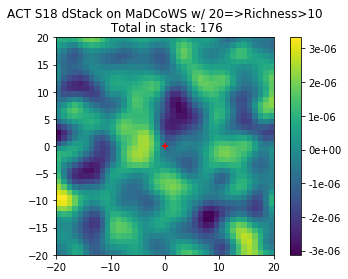

For richness bin 10 to 20 cen/cen_d = -1.0991249271842603e-06, out/out_d = -8.502609605815506e-09, s/n = 129.26912773138434
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in sta

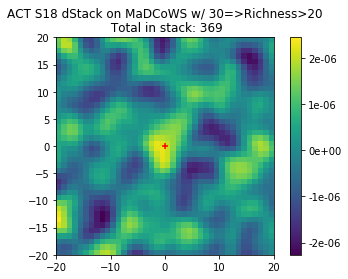

For richness bin 20 to 30 cen/cen_d = -2.144008325748536e-08, out/out_d = 1.3150340209526033e-08, s/n = -1.630382401966626
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 219
219


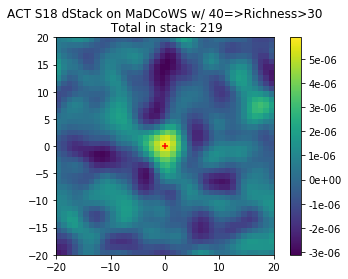

For richness bin 30 to 40 cen/cen_d = 7.248352135427849e-07, out/out_d = -4.008209405900902e-08, s/n = -18.083766094547848
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 72
72


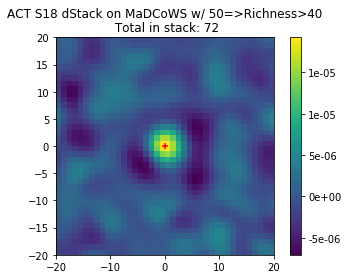

For richness bin 40 to 50 cen/cen_d = 7.991409380250025e-07, out/out_d = -1.0674496822081851e-07, s/n = -7.48645066221628
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 25
25


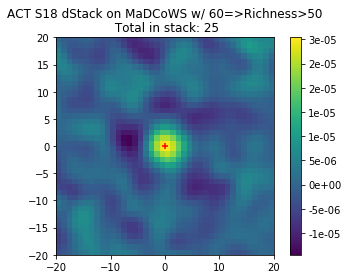

For richness bin 50 to 60 cen/cen_d = -3.7468555010360293e-06, out/out_d = 5.121059504469371e-08, s/n = -73.16563101377724
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 5
5


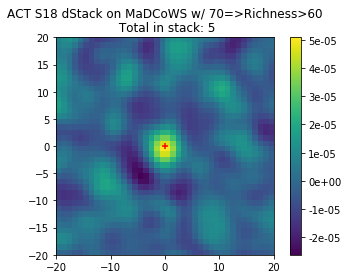

For richness bin 60 to 70 cen/cen_d = 3.235248755079596e-06, out/out_d = -1.7371014596297377e-07, s/n = -18.6244087076479
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Error: no items in stack
None
Error: No objects in stack
For  richness bin 70 to 80, no items in stack
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Error: no items in stack
None
Error: No objects in stack
For  richness bin 80 to 90, no items in stack
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Error: no items in stack
None
Error: No objects in stack
For  richness bin 90 to 100, no items in stack


In [124]:
for i in range(0, 100, 10):
    a,b = s18dStacker(mdcw_catalog, i, i+10, s18d)
    if a == None:
        print("For  richness bin {} to {}, no items in stack".format(i, i+10))
        continue
    print("For richness bin {} to {} cen/cen_d = {}, out/out_d = {}, s/n = {}".format(i, i+10, a, b, a/b))



# Individual plots of clusters not in ACT with Richness > 60

Number before confirmed removal: 2839
Number after confirmed removal: 2743
Number above cut: 2743


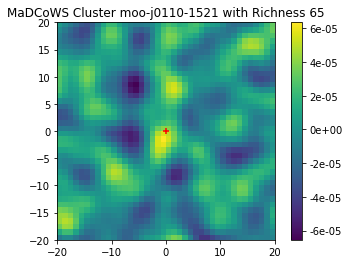

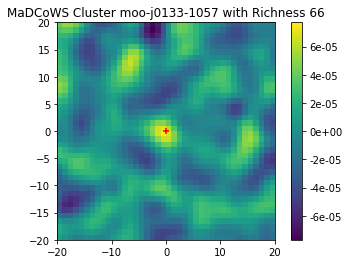

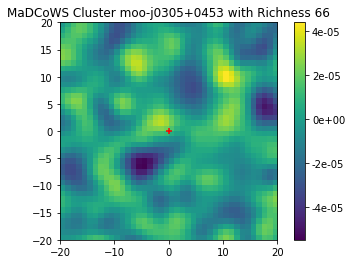

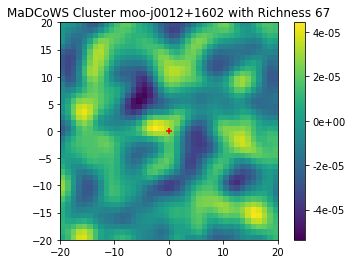

In [20]:
ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']

path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_z_independent_matches.fits')
in_act = act[1].data['MADCOWSUnion_name']

names = mdcw_catalog[1].data['name']
flags = [True]*len(ra)

for i, name in enumerate(names):
    if name in in_act:
        flags[i] = False

print("Number before confirmed removal: {}".format(len(ra)))
ra = ra[flags]
dec = dec[flags]
rich = rich[flags]
names = names[flags]
print("Number after confirmed removal: {}".format(len(ra)))

print("Number above cut: {}".format(len(ra)))    

cut = np.where((60<np.array(rich)) & (np.array(rich)<1000))[0]
cut_ra, cut_dec, cut_names, cut_rich = ra[cut], dec[cut], names[cut], rich[cut]

for i in range(len(cut_ra)):
    tileName = tileFinder(cut_ra[i], cut_dec[i], s18d)
    if tileName is None: continue
    tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
    
    name = cut_names[i]
    name = name.replace(' ', '-').lower()
    
    stamp = reproject.postage_stamp(tile, cut_ra[i], cut_dec[i], 20., 0.5)

    
    plot = plt.imshow(stamp[0], extent = [-20,20,-20,20])
    plt.scatter(0,0, marker = '+', color = 'r')
    plt.colorbar(plot, format='%.0e')
    plt.title("MaDCoWS Cluster {} with Richness {}".format(name, cut_rich[i]))
    plt.savefig(name + "_s18d_y.png")
    plt.show()
    plt.close()

# Stacking on matches, MDCWs centers

Number before confirmed removal: 2839
Number after confirmed removal: 96
Number in stack: 96


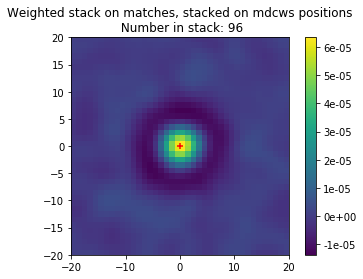

In [10]:
#Stack on MaDCoWS and ACT centers for known cross matches.
#Stacking on MaDCoWS positions
ra_mdcw = mdcw_catalog[1].data['RADeg']
names_mdcw = mdcw_catalog[1].data['name']
dec_mdcw = mdcw_catalog[1].data['decDeg']
ra_mdcw, dec_mdcw = np.array(ra_mdcw), np.array(dec_mdcw)
rich_mdcw = mdcw_catalog[1].data['Rich']

path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_z_independent_matches.fits')
in_act = act[1].data['MADCOWSUnion_name']

names = mdcw_catalog[1].data['name']
flags = [True]*len(ra_mdcw)

for i, name in enumerate(names):
    if name not in in_act:
        flags[i] = False

print("Number before confirmed removal: {}".format(len(ra_mdcw)))
ra_mdcw = ra_mdcw[flags]
dec_mdcw = dec_mdcw[flags]
rich_mdcw = rich_mdcw[flags]
names_mdcw = names_mdcw[flags]
print("Number after confirmed removal: {}".format(len(ra_mdcw)))

mdcw_s18d_stack, stack_num = s18dStack(ra_mdcw, dec_mdcw, s18d, weight = True)

"""
out, cen, cen_d, out_d = 0,0,0,0

for i in range(len(s18d_stack[0])):
    for j in range(len(s18d_stack[0])):
        if (28<i<32) & (28<j<32):
            cen += s18d_stack[i][j]
            cen_d += 1
        else:
            out += s18d_stack[i][j]
            out_d += 1
print(cen/cen_d)
print(out/out_d)
"""

plot = plt.imshow(mdcw_s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title('Weighted stack on matches, stacked on mdcws positions\n Number in stack: {}'.format(stack_num))
plt.savefig("plots/weighted_stack_mdcw_pos.png")
plt.show()
plt.close()

# Stacking on matches, ACT centers

Number before confirmed removal: 8881
Number after confirmed removal: 96
Number in stack: 96


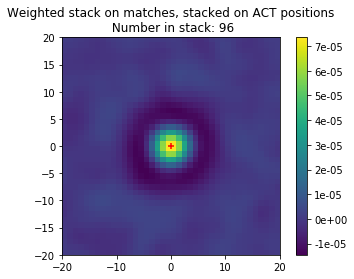

/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'act_r' is not defined

In [11]:
t = QTable.read('/scratch/r/rbond/jorlo/AdvACT2.fits')

ra_act = t['RADeg']
dec_act = t['decDeg']
names = t['name']
ra_act, dec_act = np.array(ra_act), np.array(dec_act)

path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_z_independent_matches.fits')
in_act = act[1].data['Name']

flags = [True]*len(ra_act)

for i, name in enumerate(names):
    if name not in in_act:
        flags[i] = False

print("Number before confirmed removal: {}".format(len(ra_act)))
ra_act = ra_act[flags]
dec_act = dec_act[flags]
print("Number after confirmed removal: {}".format(len(ra_act)))

act_s18d_stack, stack_num = s18dStack(ra_act, dec_act, s18d, weight = True)

"""
out, cen, cen_d, out_d = 0,0,0,0

for i in range(len(s18d_stack[0])):
    for j in range(len(s18d_stack[0])):
        if (28<i<32) & (28<j<32):
            cen += s18d_stack[i][j]
            cen_d += 1
        else:
            out += s18d_stack[i][j]
            out_d += 1
print(cen/cen_d)
print(out/out_d)
"""

plot = plt.imshow(act_s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title('Weighted stack on matches, stacked on ACT positions\n Number in stack: {}'.format(stack_num))
plt.savefig("plots/weighted_stack_ACT_pos.png")
plt.show()
plt.close()

xspline = np.linspace(-10, 10, 40)
yspline = xspline

rbin = np.linspace(0, np.sqrt(2)*max(xspline), 20)


act_r_mean, act_bin_data, c, d = binmap(act_s18d_stack,xspline,yspline,rbin)
mdcw_r_mean, mdcw_bin_data, c, d = binmap(mdcw_s18d_stack,xspline,yspline,rbin)

plt.plot(act_r_mean, act_bin_data*10**6, label = 'ACT Centered')
plt.plot(mdcw_r_mean, mdcw_bin_data*10**6, label = 'MaDCoWS Centered')
plt.title('Radial Binned Stacked')
plt.xlabel('Arcmin')
plt.ylabel('$y_0$ flux ($10^6$)')
plt.legend()
plt.savefig('comp_radial_bin.pdf')
plt.show()

In [27]:
#Jackknife error bars

jks = {'act_rs':[], 'act_bin_data':[],'mdcw_rs':[], 'mdcw_bin_data':[]}


num_jk = 96/4

xspline = np.linspace(-10, 10, 40)
yspline = xspline

rbin = np.linspace(0, np.sqrt(2)*max(xspline), 20)



chunks = np.array_split(range(len(ra_act)),num_jk)  


for j in range(int(num_jk)):

    ra_temp_act = np.delete(ra_act, chunks[j])
    dec_temp_act = np.delete(dec_act, chunks[j])
    
    ra_temp_mdcw = np.delete(ra_mdcw, chunks[j])
    dec_temp_mdcw = np.delete(dec_mdcw, chunks[j])
    rich_temp__mdcw = np.delete(rich_mdcw, chunks[j])
    names_temp_mdcw = np.delete(names_mdcw, chunks[j])

    stack_act, stack_num_act = s18dStack(ra_temp_act, dec_temp_act, s18d, weight = True)
    act_r_jk, act_bin_data_jk, c, d = binmap(stack_act,xspline,yspline,rbin)
    
    stack_mdcw, stack_num_mdcw = s18dStack(ra_temp_mdcw, dec_temp_mdcw, s18d, weight = True)
    mdcw_r_jk, mdcw_bin_data_jk, c, d = binmap(stack_mdcw,xspline,yspline,rbin)

    jks['act_rs'].append(act_r_jk)
    jks['act_bin_data'].append(act_bin_data_jk)
    jks['mdcw_rs'].append(mdcw_r_jk)
    jks['mdcw_bin_data'].append(mdcw_bin_data_jk)
    print(j)
    
pk.dump(jks, open( "weighted_centers_jks.p", "wb" ))


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'stacks' is not defined

[8.3160878062300807e-07, 5.7308106385839588e-07, 2.2345587211798888e-07, 1.1450688265514069e-07, 1.5294172701719888e-07, 1.3258894495423252e-07, 9.583013718118617e-08, 6.0747990373258713e-08, 5.6984578152905211e-08, 7.2833495528998714e-08, 6.1440228131737201e-08, 4.4057121195150942e-08, 3.4711585789134278e-08, 4.0251058811992789e-08, 4.5933101169918112e-08, 7.0896731743204462e-08, 9.6917118761319855e-08, 1.0770941391892045e-07, 1.1175903891123004e-07, 1.3291052550184456e-07]


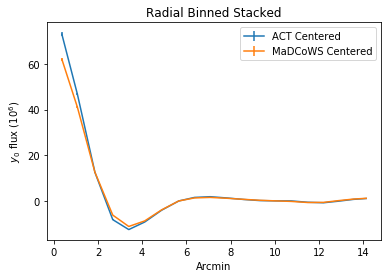

In [37]:

yerr_jk_act = []
yerr_jk_mdcw = []

for i in range(len(jks['act_bin_data'][0])):
    jks_act = []
    jks_mdcw =[]
    
    for j in range(len(jks['act_bin_data'])):
        jks_act.append(jks['act_bin_data'][j][i])
        jks_mdcw.append(jks['mdcw_bin_data'][j][i])
    yerr_jk_act.append(np.sqrt(np.var(jks_act)))
    yerr_jk_mdcw.append(np.sqrt(np.var(jks_mdcw)))   

"""
plt.errorbar(x, y, xerr = xerr, yerr = yerr_jk, ls = 'none')
plt.xticks(x[1::2])
plt.title('Unweighted Richness vs Brightest Pixel, central 4x4\n Jackknife Estimatition, 20 patches')
plt.xlabel('Richness')
plt.ylabel('Brightest Pixel')
plt.savefig('jk_brightrich_unweighted.pdf')
plt.show()
"""
print(yerr_jk_act)

plt.errorbar(act_r, act_bin_data*10**6, yerr = (np.array(yerr_jk_act)*10**6), label = 'ACT Centered')
plt.errorbar(mdcw_r, mdcw_bin_data*10**6, yerr = (np.array(yerr_jk_mdcw)*10**6), label = 'MaDCoWS Centered')
plt.title('Radial Binned Stacked')
plt.xlabel('Arcmin')
plt.ylabel('$y_0$ flux ($10^6$)')
plt.legend()
plt.savefig('comp_radial_bin.pdf')
plt.show()

In [12]:
#Bootstrap 

bootstraps = {'act_rs':[], 'act_bin_data':[],'mdcw_rs':[], 'mdcw_bin_data':[]}

for j in range(50):
    flags = np.random.randint(len(ra_act), size = len(ra_act))


    ra_temp_act = ra_act[flags]
    dec_temp_act = dec_act[flags]
    
    ra_temp_mdcw = ra_mdcw[flags]
    dec_temp_mdcw = dec_mdcw[flags]

    stack_act, stack_num_act = s18dStack(ra_temp_act, dec_temp_act, s18d, weight = True)
    act_r_jk, act_bin_data_jk, c, d = binmap(stack_act,xspline,yspline,rbin)
    
    stack_mdcw, stack_num_mdcw = s18dStack(ra_temp_mdcw, dec_temp_mdcw, s18d, weight = True)
    mdcw_r_jk, mdcw_bin_data_jk, c, d = binmap(stack_mdcw,xspline,yspline,rbin)

    bootstraps['act_rs'].append(act_r_jk)
    bootstraps['act_bin_data'].append(act_bin_data_jk)
    bootstraps['mdcw_rs'].append(mdcw_r_jk)
    bootstraps['mdcw_bin_data'].append(mdcw_bin_data_jk)
    print(j)
    
pk.dump(bootstraps, open( "weighted_centers_bootstraps.p", "wb" ))


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
0


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
1


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
2


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
3


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
4


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
5


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
6


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
7


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
8


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
9


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
10


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
11


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
12


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
13


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
14


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
15


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
16


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
17


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
18


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
19


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
20


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
21


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
22


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
23


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
24


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
25


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
26


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
27


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
28


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
29


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
30


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
31


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
32


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
33


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
34


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
35


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
36


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
37


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
38


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
39


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
40


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
41


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
42


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
43


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
44


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
45


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
46


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
47


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
48


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 96
49


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[3.676812173451982e-06, 2.5059957998286743e-06, 1.0287876512437405e-06, 5.6676482459467357e-07, 7.2580415471591133e-07, 6.6409365504371959e-07, 5.0594459474113443e-07, 3.2759218803227988e-07, 2.4876120350250074e-07, 2.5555908501844955e-07, 2.4408871313479831e-07, 2.4465390917048349e-07, 2.544839537259718e-07, 1.8936790150906904e-07, 2.2264196240233965e-07, 3.0752173226654202e-07, 3.42486928044735e-07, 4.2890665862822019e-07, 5.5871036407142336e-07, 6.1936177835573393e-07]


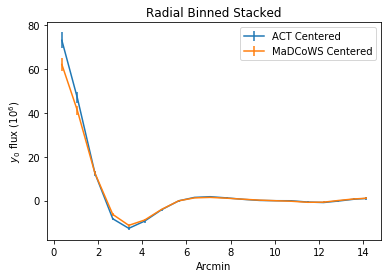

In [14]:
yerr_boot_act = []
yerr_boot_mdcw = []

for i in range(len(bootstraps['act_bin_data'][0])):
    boot_act = []
    boot_mdcw =[]
    
    for j in range(len(bootstraps['act_bin_data'])):
        boot_act.append(bootstraps['act_bin_data'][j][i])
        boot_mdcw.append(bootstraps['mdcw_bin_data'][j][i])
    yerr_boot_act.append(np.sqrt(np.var(boot_act)))
    yerr_boot_mdcw.append(np.sqrt(np.var(boot_mdcw)))   

"""
plt.errorbar(x, y, xerr = xerr, yerr = yerr_jk, ls = 'none')
plt.xticks(x[1::2])
plt.title('Unweighted Richness vs Brightest Pixel, central 4x4\n Jackknife Estimatition, 20 patches')
plt.xlabel('Richness')
plt.ylabel('Brightest Pixel')
plt.savefig('jk_brightrich_unweighted.pdf')
plt.show()
"""
print(yerr_boot_act)

plt.errorbar(act_r_mean, act_bin_data*10**6, yerr = (np.array(yerr_boot_act)*10**6), label = 'ACT Centered')
plt.errorbar(mdcw_r_mean, mdcw_bin_data*10**6, yerr = (np.array(yerr_boot_mdcw)*10**6), label = 'MaDCoWS Centered')
plt.title('Radial Binned Stacked')
plt.xlabel('Arcmin')
plt.ylabel('$y_0$ flux ($10^6$)')
plt.legend()
plt.savefig('comp_radial_bin.pdf')
plt.show()

# Add Scatter to ACT Centers

In [ ]:
t = QTable.read('/scratch/r/rbond/jorlo/AdvACT2.fits')

ra_act = t['RADeg']
dec_act = t['decDeg']
names = t['name']
ra_act, dec_act = np.array(ra_act), np.array(dec_act)

act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_z_independent_matches.fits')
in_act = act[1].data['ACT Cluster']

flags = [True]*len(ra_act)

for i, name in enumerate(names):
    if name not in in_act:
        flags[i] = False

print("Number before confirmed removal: {}".format(len(ra_act)))
ra_act = ra_act[flags]
dec_act = dec_act[flags]
print("Number after confirmed removal: {}".format(len(ra_act)))

ra_act, dec_act = np.array(ra_act), np.array(dec_act)

test = offsetSim(ra_act, dec_act, '1_arcmin_scatter.p')

Number before confirmed removal: 8881
Number after confirmed removal: 89
Number in stack: 89
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
24


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
25


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
26


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
27


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
28


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
29


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
30


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 89
31


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Looking at brightness by richness bin

In [110]:

def richStat(data, catalog, r_low, r_high, bins = 1, save_plot = False):
    ra = catalog[1].data['RADeg']
    names = catalog[1].data['name']
    dec = catalog[1].data['decDeg']
    ra, dec = np.array(ra), np.array(dec)
    rich = catalog[1].data['Rich']
    names = catalog[1].data['name']
    path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

    cut = np.where((r_low<np.array(rich)) & (np.array(rich)<=r_high))[0]
    cut_ra, cut_dec, cut_names, cut_rich = ra[cut], dec[cut], names[cut], rich[cut]
    
    if bins == 1:
        stack, num = s18dStack(cut_ra, cut_dec, data)

        plot = plt.imshow(stack)
        plt.colorbar(plot, format='%.0e')
        plt.title("ACT S18 dStack on MaDCoWS w/ {}=>Richness>{}\n Total in stack: {}".format(r_high, r_low, num))

        plt.show()
        mean = np.amax(stack[18:22, 18:22])

        brights = []
        for i in range(len(cut_ra)):
            stamp = s18dStamp(cut_ra[i], cut_dec[i], s18d, 'fakename', width = 1/3, write = False)
            if stamp is None: continue
            brights.append(np.amax(stamp[0][18:22, 18:22]))

            if save_plot:
                plot = plt.imshow(stamp[0], extent = [-20,20,-20,20])
                plt.scatter(0,0, marker = '+', color = 'r')
                plt.colorbar(plot, format='%.0e')
                plt.title('Cluster {}, {}th Percentile'.format(cut_names[i], round(100/(bin))))

                plt.savefig('plots/indv_clusters/' + str(cut_names[i]) + '.png')
                plt.close()

        var = np.var(brights)
        #print(brights)
    
        return mean, var
    else:
        percs = [r_low]
        means = []
        varies =[]
        #NOTE: Percentiles are in terms of the full MaDCoWS catalog: these will not neccesarily be exactly the
        #percentiles for the subset of the clusters that are in the s18d footprint
        for i in range(bins):
            perc = np.percentile(cut_rich, (i+1)*100/(bins))
            percs.append(perc)
        for i in range(bins):
            flags2 = np.where((percs[i] < cut_rich) & (cut_rich <= percs[i+1]))[0]
            cut_ra2, cut_dec2, cut_names2, cut_rich2 = cut_ra[flags2], cut_dec[flags2], cut_names[flags2], cut_rich[flags2]
        
            stack, num = s18dStack(cut_ra2, cut_dec2, data)

            plot = plt.imshow(stack, extent = [-20,20,-20,20])
            plt.colorbar(plot, format='%.0e')
            plt.scatter(0,0, marker = '+', color = 'r')
            
            plt.title("ACT S18d Stack on MaDCoWS w/ {}=>Richness>{}\n {} to {}th percentile, total in stack: {}".format(r_high, r_low, int((i)*100/(bins)), int((i+1)*100/(bins)), num))
            plt.savefig('plots/rich_bins/rich_bin_{}_{}_{}_rich_perc.png'.format(r_low, r_high, int((i+1)*100/(bins))))
            plt.show()
            mean = np.amax(stack[18:22, 18:22])

            brights = []
            for i in range(len(cut_ra2)):
                stamp = s18dStamp(cut_ra2[i], cut_dec2[i], s18d, 'fakename', width = 1/3, write = False)
                if stamp is None: continue
                brights.append(np.amax(stamp[0][18:22, 18:22]))

                if save_plot:
                    plot = plt.imshow(stamp[0], extent = [-20,20,-20,20])
                    plt.scatter(0,0, marker = '+', color = 'r')
                    plt.colorbar(plot, format='%.0e')
                    plt.title('Cluster {}, {}th Richness Percentile'.format(cut_names2[i], int((i+1)*100/(bins))))
                    
                    plt.savefig('plots/indv_clusters/' + str(cut_names2[i]) + '_richness_' + str(cut_rich2[i]) + '_perc_' + str(int((i+1)*100/(bins))) + '.png')
                    plt.close()

            var = np.var(brights)
            varies.append(np.sqrt(var))
            means.append(mean)
            
        return means, varies
    

# Stacking in richness bins, quartiles of richness

Number in stack: 28


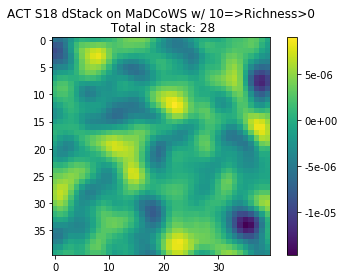

1.18257606444e-05
Number in stack: 178


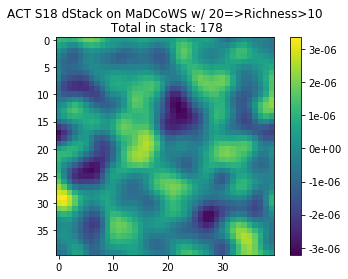

1.49838762966e-05
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 376


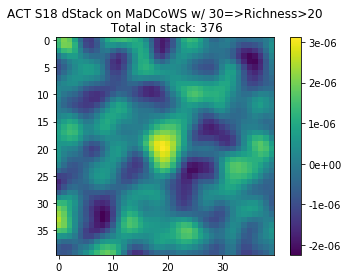

1.60489309828e-05
Number in stack: 233


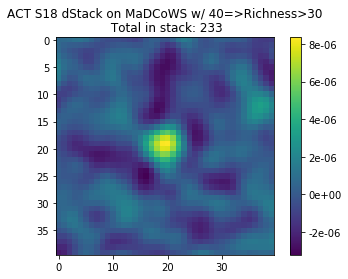

1.87012302936e-05
Number in stack: 89


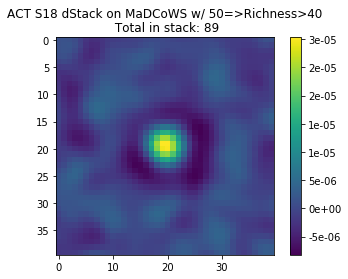

3.53194427629e-05
Number in stack: 33


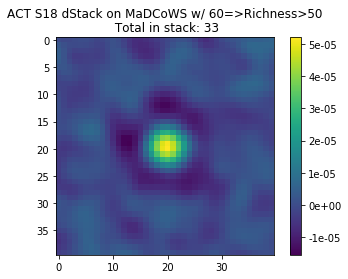

5.71648651158e-05
Number in stack: 7


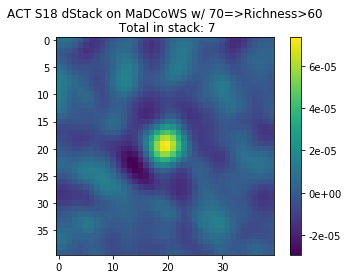

4.4753701463e-05


In [13]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

means = []
for i in range(0, 70, 10):
    mean, ignore = richStat(s18d, mdcw_catalog, i, i + 10)
    means.append(mean)
    print(np.sqrt(ignore))

Number in stack: 12


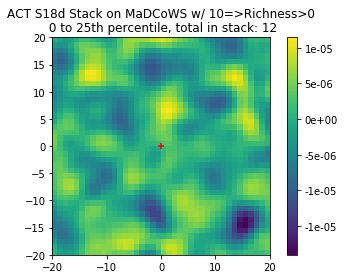

Number in stack: 1


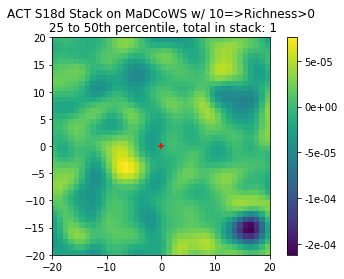

Number in stack: 9


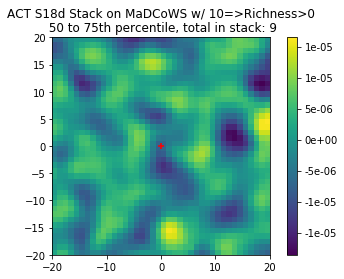

Number in stack: 6


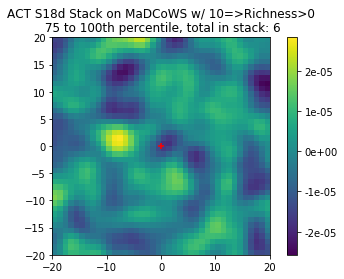

Number in stack: 62


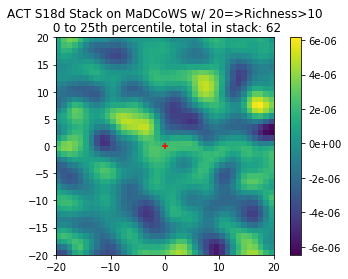

Number in stack: 46


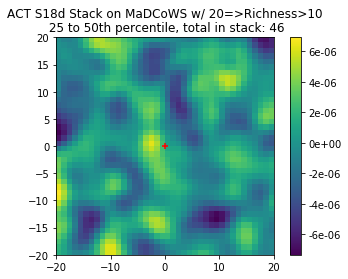

Number in stack: 40


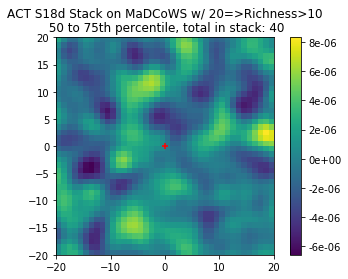

Number in stack: 30


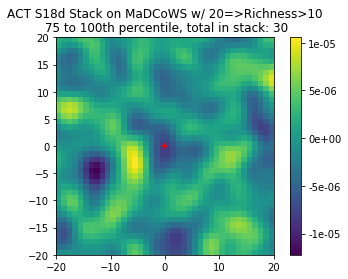

Number in stack: 115


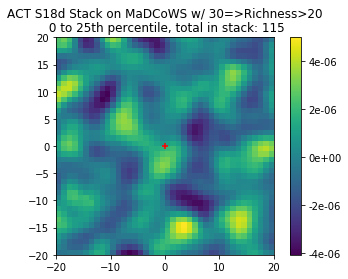

Number in stack: 71


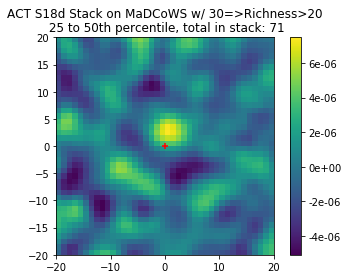

3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 115


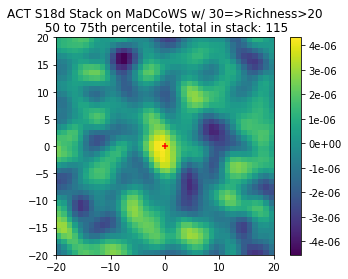

Number in stack: 75


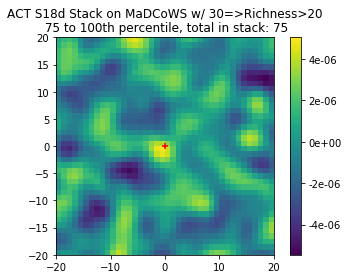

Number in stack: 83


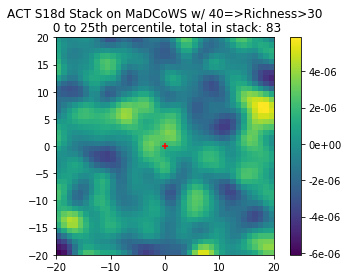

Number in stack: 56


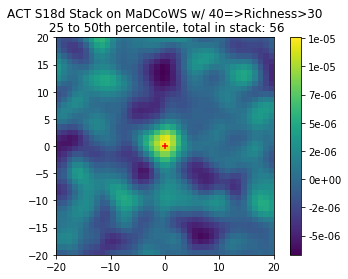

Number in stack: 54


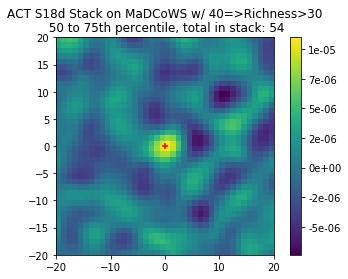

Number in stack: 40


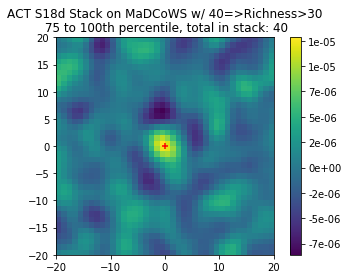

Number in stack: 31


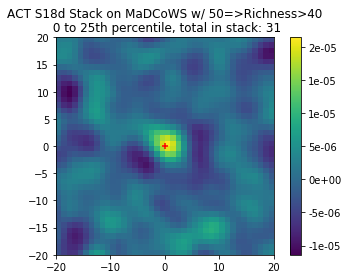

Number in stack: 20


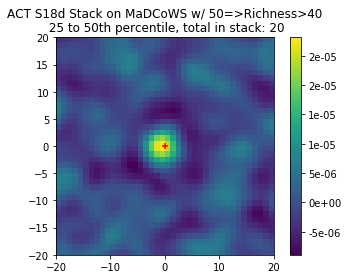

Number in stack: 20


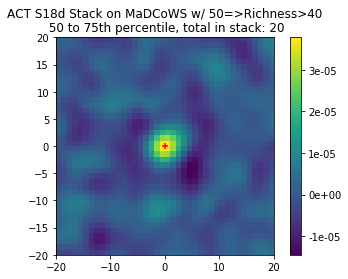

Number in stack: 18


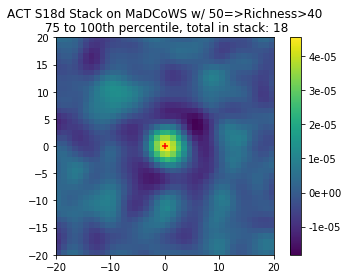

Number in stack: 15


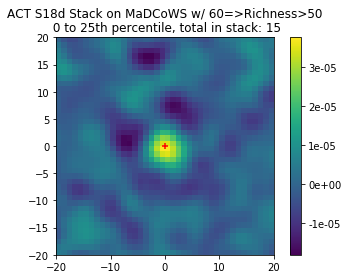

Number in stack: 5


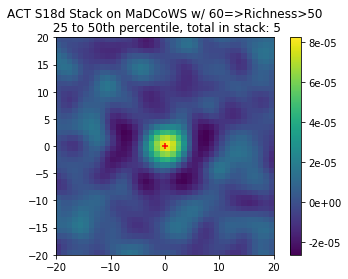

Number in stack: 7


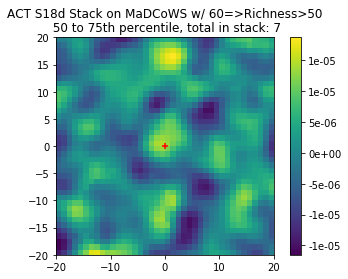

Number in stack: 6


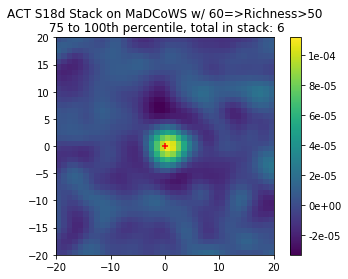

In [32]:
long_means =[]
long_vars = []
for i in range(0, 60, 10):
    mean, var = richStat(s18d, mdcw_catalog, i, i+10, bins = 4, save_plot = True)
    long_means.append(mean)
    long_vars.append(var)

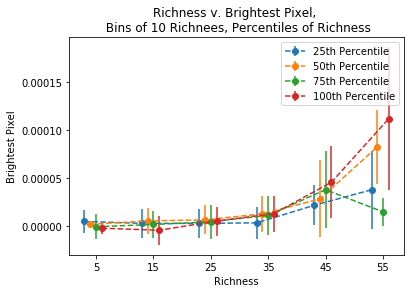

In [19]:
temp_var = np.transpose(long_vars)
temp = np.transpose(long_means)
for i in range(len(temp)):
    plt.errorbar( range(3+i,63+i, 10),temp[i], yerr= temp_var[i], label = str(int((i+1)*100/(len(temp))))+'th Percentile', marker='o',linestyle="dashed")
plt.legend()
plt.xlabel('Richness')
plt.xticks(range(5, 65, 10))
plt.ylabel('Brightest Pixel')
plt.title('Richness v. Brightest Pixel, \n Bins of 10 Richnees, Percentiles of Richness')
plt.savefig('richness-brightness.png')
plt.show()

# Stacking in bins of richness, brightness bin

In [28]:
#Now still binning in Richness but in percentiles of brightest pixel (center 4x4 pixels)
def richStatBright(data, catalog, r_low, r_high, bins = 1, save_plot = False):
    ra = catalog[1].data['RADeg']
    names = catalog[1].data['name']
    dec = catalog[1].data['decDeg']
    ra, dec = np.array(ra), np.array(dec)
    rich = catalog[1].data['Rich']
    names = catalog[1].data['name']
    path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

    cut = np.where((r_low<np.array(rich)) & (np.array(rich)<=r_high))[0]
    cut_ra, cut_dec, cut_names, cut_rich = ra[cut], dec[cut], names[cut], rich[cut]
    
    stack, num = s18dStack(cut_ra, cut_dec, data)

    #plot = plt.imshow(stack)
    #plt.colorbar(plot, format='%.0e')
    #plt.title("ACT S18 dStack on MaDCoWS w/ {}=>Richness>{}\n Total in stack: {}".format(r_high, r_low, num))

    #plt.show()
    #mean = np.amax(stack[18:22, 18:22])

    brights = []
    for i in range(len(cut_ra)):
        stamp = s18dStamp(cut_ra[i], cut_dec[i], s18d, 'fakename', width = 1/3, write = False)
        if stamp is None: continue
        brights.append(np.amax(stamp[0][18:22, 18:22]))



    
    percs = [0]
    means = []
    varies = []
    #NOTE: Percentiles are in terms of the full MaDCoWS catalog: these will not neccesarily be exactly the
    #percentiles for the subset of the clusters that are in the s18d footprint
    for i in range(bins):
        perc = np.percentile(brights, (i+1)*100/(bins))
        percs.append(perc)
        
    for i in range(bins):
        flag = np.where((percs[i] < np.array(brights)) & (np.array(brights) <= percs[i+1]))[0]
        
        cut_ra2, cut_dec2, cut_names2, brights2 = cut_ra[flag], cut_dec[flag], cut_names[flag], np.array(brights)[flag]
        
        stack, num = s18dStack(cut_ra2, cut_dec2, data)
        
        plot = plt.imshow(stack, extent = [-20,20,-20,20])
        plt.scatter(0,0, marker = '+', color = 'r')
        plt.colorbar(plot, format='%.0e')
        plt.title("ACT S18d Stack on MaDCoWS w/ {}=>Richness>{}\n {} to {}th brightness percentile, total in stack: {}".format(r_high, r_low, int((i)*100/(bins)), int((i+1)*100/(bins)), num))
        plt.savefig('plots/rich_bins/rich_bin_{}_{}_{}_bright_perc.png'.format(r_low, r_high, int((i+1)*100/(bins))))
        plt.show()
        plt.close()

        means.append(np.amax(stack[18:22, 18:22]))
        var = np.var(brights2)
        varies.append(np.sqrt(var))
        
    return means, varies

Number in stack: 28
Number in stack: 3


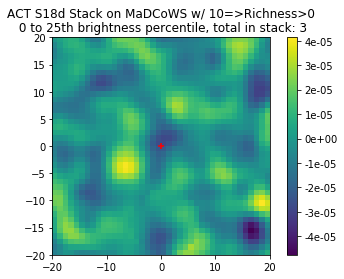

Number in stack: 5


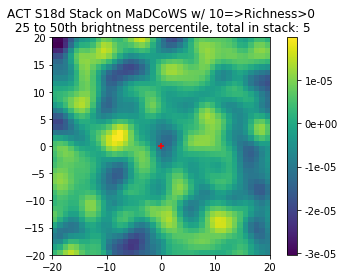

Number in stack: 5


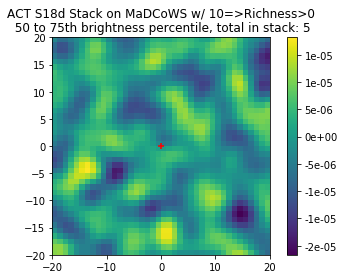

Number in stack: 5


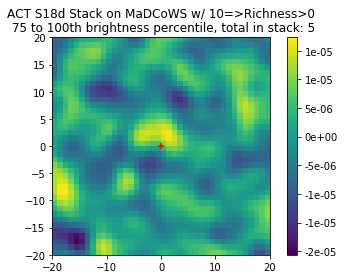

Number in stack: 178
Number in stack: 7


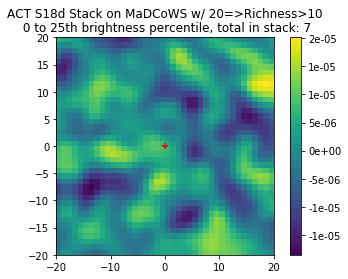

Number in stack: 21


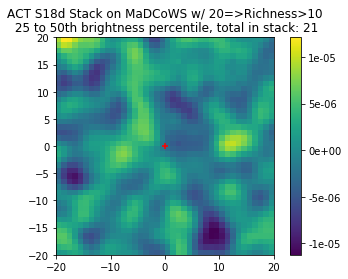

Number in stack: 30


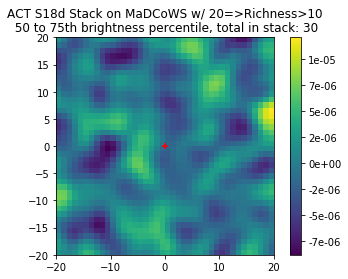

Number in stack: 27


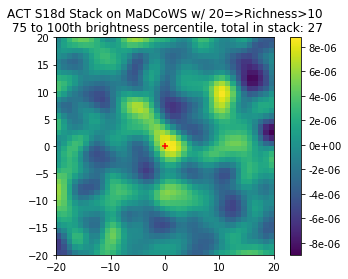

3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 376
Number in stack: 38


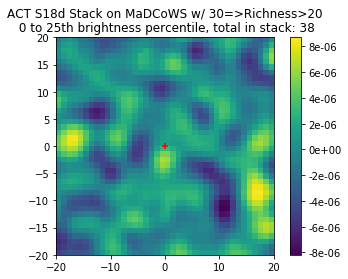

3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 54


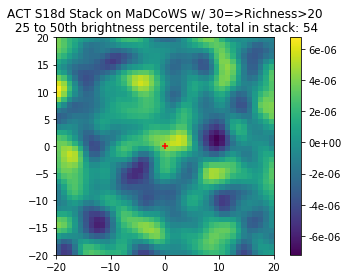

Number in stack: 58


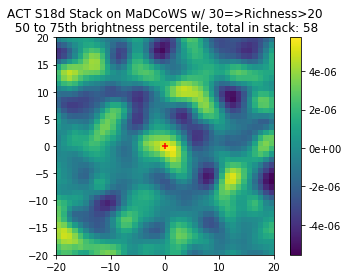

Number in stack: 60


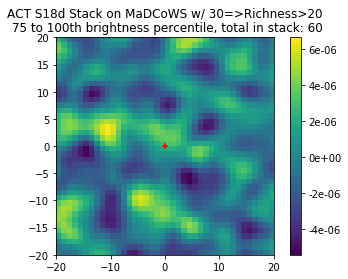

Number in stack: 233
Number in stack: 21


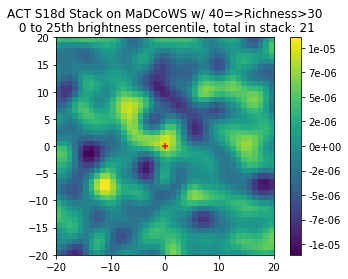

Number in stack: 29


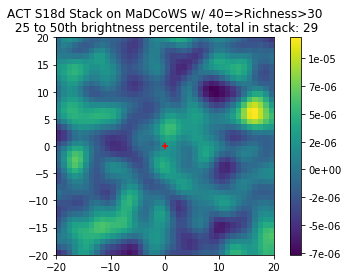

Number in stack: 27


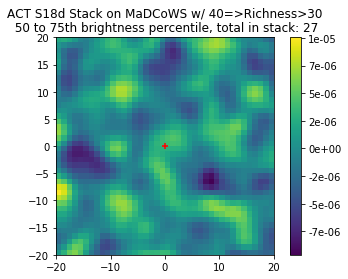

Number in stack: 35


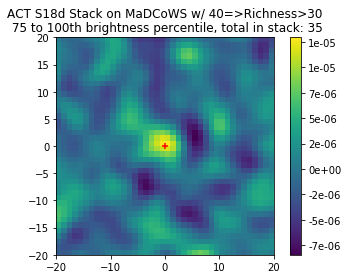

Number in stack: 89
Number in stack: 11


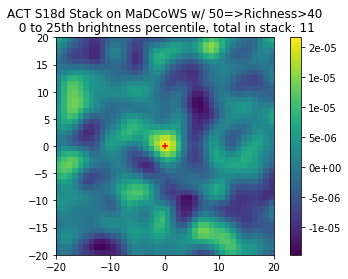

Number in stack: 12


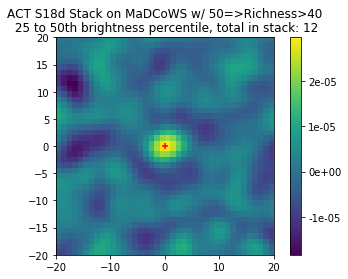

Number in stack: 13


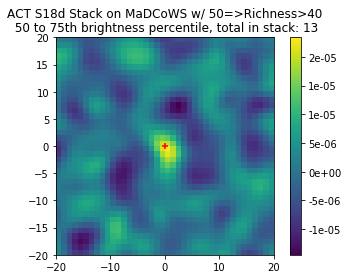

Number in stack: 7


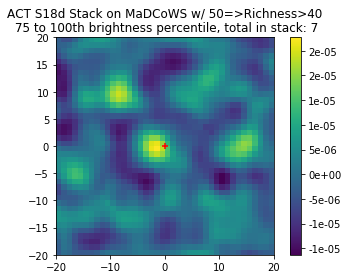

Number in stack: 33
Number in stack: 4


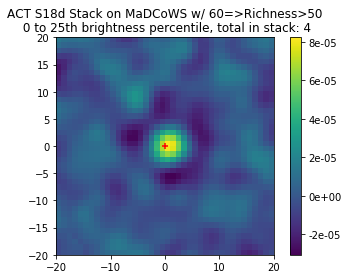

Number in stack: 4


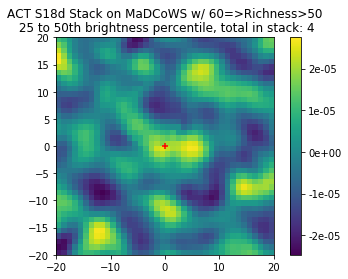

Number in stack: 5


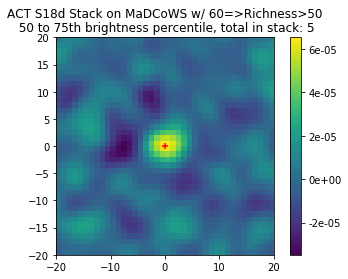

Number in stack: 3


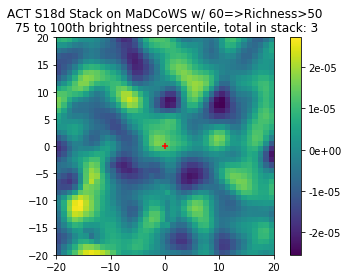

In [29]:
long_means2 = []
long_vars2 = []
for i in range(0, 60, 10):
    mean, var = richStatBright(s18d, mdcw_catalog, i, i+10, bins = 4)
    long_means2.append(mean)
    long_vars2.append(var)
    

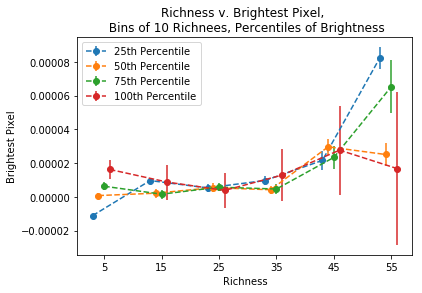

In [30]:
temp2 = np.transpose(long_means2)
temp_var2 = np.transpose(long_vars2)
for i in range(len(temp)):
    plt.errorbar( range(3+i,63+i, 10),temp2[i], yerr = temp_var2[i], label = str(int((i+1)*100/(len(temp))))+'th Percentile', marker='o',linestyle="dashed")
plt.legend()
plt.xlabel('Richness')
plt.xticks(range(5, 65, 10))
plt.ylabel('Brightest Pixel')
plt.title('Richness v. Brightest Pixel, \n Bins of 10 Richnees, Percentiles of Brightness')
plt.savefig('richness-brightness2.png')
plt.show()

# Inverse Noise weighted stacking


In [38]:
rms = fits.open('/scratch/r/rbond/jorlo/S18d_202006/selFn/RMSMap_Arnaud_M2e14_z0p4.fits')


In [11]:
#i=10
#plots = enplot.plot(rms[i].data,mask=0)
#enplot.show(plots)

mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

mdcw_ra = mdcw_catalog[1].data['RADeg']
mdcw_dec =mdcw_catalog[1].data['decDeg']

#print(mdcw_ra[5])

tileName = tileFinder(3.63875, -9.15638888889, s18d)
print(tileName)
path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'
#tileName = rms[i].header['EXTNAME']
tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+str(tileName)+'_filteredMap.fits')

#test = enmap.read_map('/scratch/r/rbond/jorlo/S18d_202006/selFn/RMSMap_Arnaud_M2e14_z0p4.fits')
#plt.imshow(tile, vmin=-1e-6,vmax=1e-6)
#plt.colorbar()
#plt.show()

for i in range(1,500):
    if rms[i].header['EXTNAME'] == tileName:
        temp = i
        break
print(i)

rmsmap = rms[i].data
print(rmsmap.shape)

coords = np.deg2rad(np.array(( -18.5816666667, 206.622916667)))
ypix,xpix = enmap.sky2pix(tile.shape,tile.wcs,coords)

print('{},{}'.format(ypix,xpix))

#ypix = 100 ; xpix = 300
#pixes = np.array((ypix,xpix))
#dec,ra = enmap.pix2sky(tile.shape,tile.wcs,pixes)
#ra, dec = np.rad2deg([ra,dec])
#print('{},{}'.format(ra,dec))

weight = rmsmap[int(ypix),int(xpix)]
print(weight**2)

1_9_7
144
(882, 1468)
-659.8000000040083,19808.24999996007


IndexError: index 19808 is out of bounds for axis 1 with size 1468

# Stacking in decade bins of richness

In [9]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')
rms = fits.open('/scratch/r/rbond/jorlo/S18d_202006/selFn/RMSMap_Arnaud_M2e14_z0p4.fits')


ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']

path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

"""
act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_z_independent_matches.fits')
in_act = act[1].data['MADCOWSUnion_name']

names = mdcw_catalog[1].data['name']
flags = [True]*len(ra)

for i, name in enumerate(names):
    if name not in in_act:
        flags[i] = True

print("Number before confirmed removal: {}".format(len(ra)))
ra = ra[flags]
dec = dec[flags]
rich = rich[flags]
names = names[flags]
print("Number after confirmed removal: {}".format(len(ra)))
#print(rich)
"""
flags = np.where((rich < 1000) & (rich>0))[0]

print('Number before no richness removal: {}'.format(len(ra)))
ra = ra[flags]
dec = dec[flags]
rich = rich[flags]
names = names[flags]
print('Number after no richness removal: {}'.format(len(ra)))

flags = getFlags(ra, dec, s18d)

print('Number before outside map removal: {}'.format(len(ra)))
ra = ra[flags]
dec = dec[flags]
rich = rich[flags]
names = names[flags]
print('Number after outside map removal: {}'.format(len(ra)))

bins = 10

perc = np.percentile(rich, np.linspace(0,100, bins+1))
perc[0] = perc[0]-1

stacks = []
stack_nums = []
for i in range(bins):
    cut = np.where((rich>perc[i]) & (rich <= perc[i+1]))[0]
    
    ra_cut = ra[cut]
    dec_cut = dec[cut]
    rich_cut = rich[cut]
    names_cut = names[cut]
    
    stack, stack_num = s18dStack(ra_cut, dec_cut, s18d)#, weight = True)
    
    stacks.append(stack)
    stack_nums.append(stack_num)

pk.dump(stacks, open( "unweighted_stacks.p", "wb" ))


Number before confirmed removal: 2839
Number after confirmed removal: 2839
Number before no richness removal: 2839
Number after no richness removal: 1869
Number before outside map removal: 1869
Number after outside map removal: 1012
Number in stack: 112
Number in stack: 107
Number in stack: 122
Number in stack: 75
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.3728148

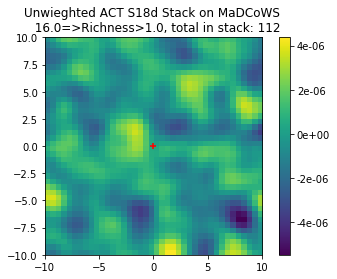

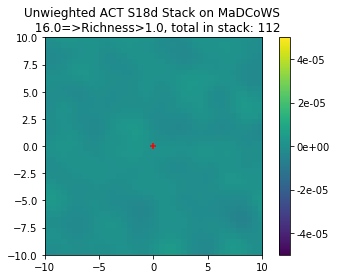

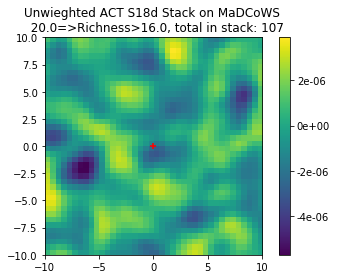

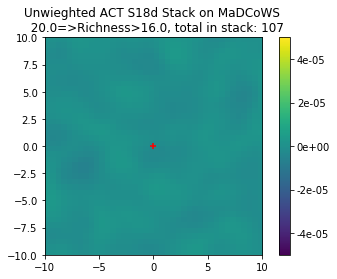

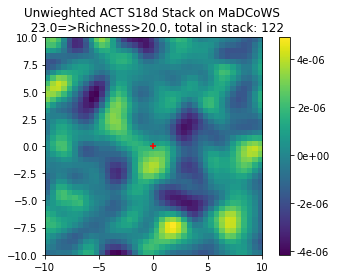

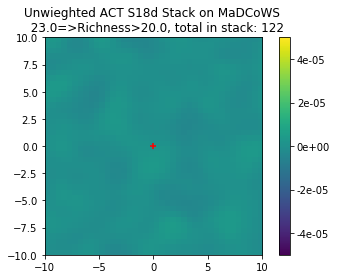

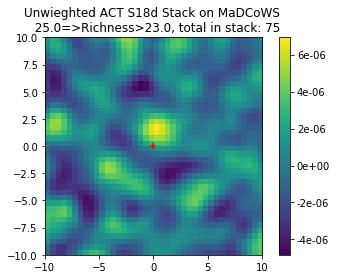

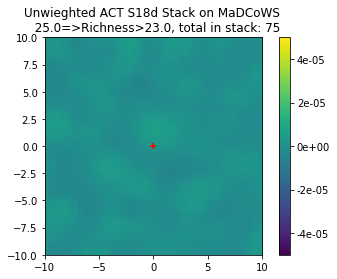

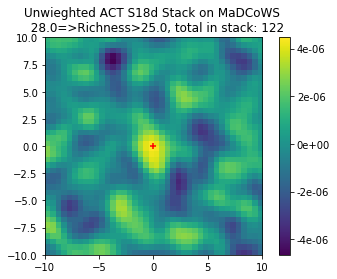

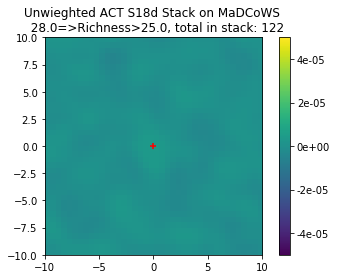

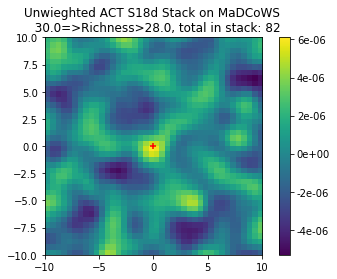

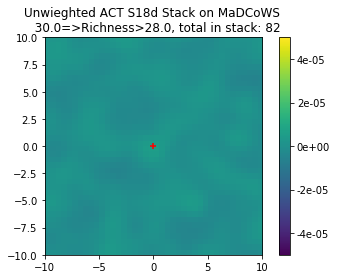

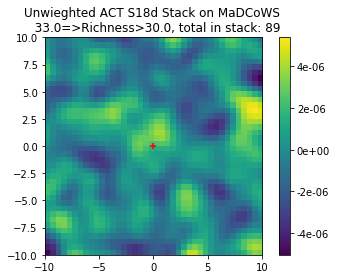

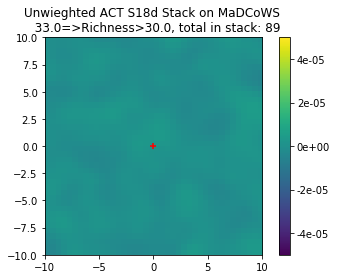

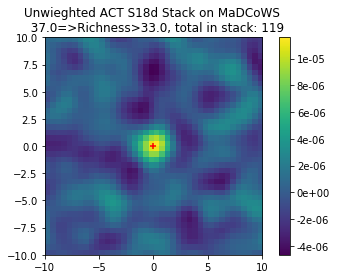

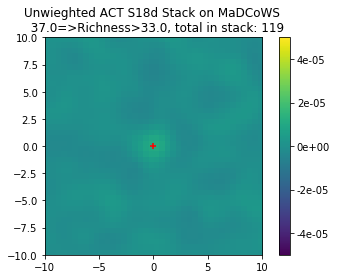

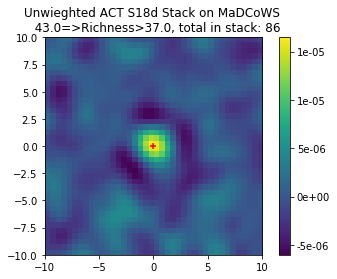

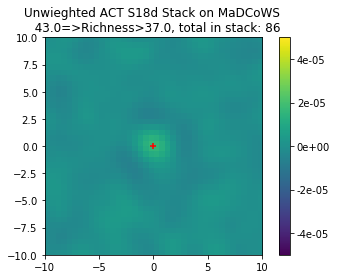

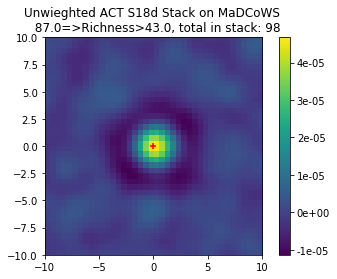

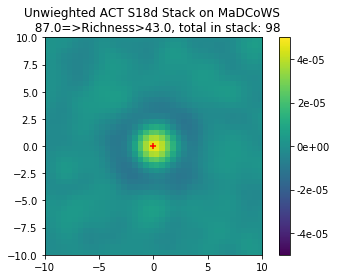

In [95]:
#norm = matplotlib.colors.Normalize(vmin=-1.5*10**-5, vmax = 5*10**-5)
#cmap = matplotlib.cm.PRGn
#sm = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)


for i in range(len(perc)-1):
    width = 0.5*len(stacks[i][0])/2
    
    plot = plt.imshow(stacks[i],  extent = [-width,width,-width,width])
    plt.scatter(0,0, marker = '+', color = 'r')
    #plt.clim(vmin, vmax);
    plt.colorbar(plot, format='%.0e')
    #plt.pcolor(X, Y, f(data), cmap=cm, vmin=-4, vmax=4)

    plt.title("Unwieghted ACT S18d Stack on MaDCoWS \n  {}=>Richness>{}, total in stack: {}".format(perc[i+1], perc[i], stack_nums[i]))
    plt.savefig('plots/inv_noise/rich_bin_{}_unnormed_unweighted.pdf'.format(perc[i+1]))
    plt.show()
    plt.close()
    
    width = 0.5*len(stacks[i][0])/2
    vmin, vmax = -5*10**-5, 5*10**-5
    plot = plt.imshow(stacks[i],  extent = [-width,width,-width,width],vmin = vmin, vmax = vmax)
    plt.scatter(0,0, marker = '+', color = 'r')
    #plt.clim(vmin, vmax);
    plt.colorbar(plot, format='%.0e')
    #plt.pcolor(X, Y, f(data), cmap=cm, vmin=-4, vmax=4)

    plt.title("Unwieghted ACT S18d Stack on MaDCoWS \n  {}=>Richness>{}, total in stack: {}".format(perc[i+1], perc[i], stack_nums[i]))
    plt.savefig('plots/inv_noise/rich_bin_{}_normed_unweighted.pdf'.format(perc[i+1]))
    plt.show()
    plt.close()

# Bootstraping 

In [53]:
for stack in stacks:
    print(np.amax(stack[18:22, 18:22]))
    
bootstraps = {}
for i in range(bins):
    
    bootstraps['{}'.format(i)] = []
    
    cut = np.where((rich>perc[i]) & (rich <= perc[i+1]))[0]
    
    ra_cut = ra[cut]
    dec_cut = dec[cut]
    rich_cut = rich[cut]
    names_cut = names[cut]
    for j in range(50):
        flags = np.random.randint(len(ra_cut), size = len(ra_cut))
        
        #print(flags)
        
        ra_temp = ra_cut[flags]
        dec_temp = dec_cut[flags]
        rich_temp = rich_cut[flags]
        names_temp = names_cut[flags]
        
        #print(ra_temp)
        
        stack, stack_num = s18dStack(ra_temp, dec_temp)#, s18d, weight = True)
    
        bootstraps['{}'.format(i)].append(stack)
        #stack_nums.append(stack_num)
        
        print(j)
pk.dump(stacks, open( "unweighted_bootstraps.p", "wb" ))


1.771731811280605e-06
-2.80965149153559e-07
2.766971127653564e-06
5.348498109693993e-06
4.4710829725585055e-06
6.108951715767483e-06
3.694561843937735e-06
1.1578612747584404e-05
1.6480170028452538e-05
4.6723650364603704e-05
Number in stack: 112
0
Number in stack: 112
1
Number in stack: 112
2
Number in stack: 112
3
Number in stack: 112
4
Number in stack: 112
5
Number in stack: 112
6
Number in stack: 112
7
Number in stack: 112
8
Number in stack: 112
9
Number in stack: 112
10
Number in stack: 112
11
Number in stack: 112
12
Number in stack: 112
13
Number in stack: 112
14
Number in stack: 112
15
Number in stack: 112
16
Number in stack: 112
17
Number in stack: 112
18
Number in stack: 112
19
Number in stack: 112
20
Number in stack: 112
21
Number in stack: 112
22
Number in stack: 112
23
Number in stack: 112
24
Number in stack: 112
25
Number in stack: 112
26
Number in stack: 112
27
Number in stack: 112
28
Number in stack: 112
29
Number in stack: 112
30
Number in stack: 112
31
Number in stack: 1

Number in stack: 122
4
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.4207696

Number in stack: 122
15
Number in stack: 122
16
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 122
17
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1

Number in stack: 122
26
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.420769

Number in stack: 122
37
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.420769

Number in stack: 89
28
Number in stack: 89
29
Number in stack: 89
30
Number in stack: 89
31
Number in stack: 89
32
Number in stack: 89
33
Number in stack: 89
34
Number in stack: 89
35
Number in stack: 89
36
Number in stack: 89
37
Number in stack: 89
38
Number in stack: 89
39
Number in stack: 89
40
Number in stack: 89
41
Number in stack: 89
42
Number in stack: 89
43
Number in stack: 89
44
Number in stack: 89
45
Number in stack: 89
46
Number in stack: 89
47
Number in stack: 89
48
Number in stack: 89
49
Number in stack: 119
0
Number in stack: 119
1
Number in stack: 119
2
Number in stack: 119
3
Number in stack: 119
4
Number in stack: 119
5
Number in stack: 119
6
Number in stack: 119
7
Number in stack: 119
8
Number in stack: 119
9
Number in stack: 119
10
Number in stack: 119
11
Number in stack: 119
12
Number in stack: 119
13
Number in stack: 119
14
Number in stack: 119
15
Number in stack: 119
16
Number in stack: 119
17
Number in stack: 119
18
Number in stack: 119
19
Number in stack: 119
20


In [54]:
y = []
yerr = []

for i in range(len(stacks)):
    y.append(np.amax(stacks[i][18:22, 18:22]))
    straps = []
    for j in range(len(bootstraps['{}'.format(i)])):
        cur_stack = bootstraps['{}'.format(i)][j]
        straps.append(np.amax(cur_stack[18:22, 18:22]))
    yerr.append(np.sqrt(np.var(straps)))
    

In [55]:
print(y)
print(yerr)

[array(1.771731811280605e-06), array(-2.80965149153559e-07), array(2.766971127653564e-06), array(5.348498109693993e-06), array(4.4710829725585055e-06), array(6.108951715767483e-06), array(3.694561843937735e-06), array(1.1578612747584404e-05), array(1.6480170028452538e-05), array(4.6723650364603704e-05)]
[1.2673944810640813e-06, 1.5156588093098403e-06, 1.4190012575163116e-06, 2.0548849624723957e-06, 1.7972020628786408e-06, 1.8757326882815041e-06, 1.4230174650606365e-06, 2.0060672384370488e-06, 2.6503139177875736e-06, 5.6746656588074051e-06]


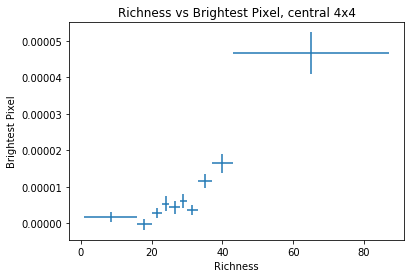

In [56]:
x = []
xerr = []

for i in range(len(perc)-1):
    x.append((perc[i]+perc[i+1])/2)
    xerr.append((perc[i+1]-perc[i])/2)
plt.errorbar(x, y, xerr = xerr, yerr = yerr, ls = 'none')
plt.title('Unweighted Richness vs Brightest Pixel, central 4x4')
plt.xlabel('Richness')
plt.ylabel('Brightest Pixel')
plt.savefig('brightrich_unweighted.pdf')
plt.show()

# Jackknife Null Test


3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 506
Number in stack: 506


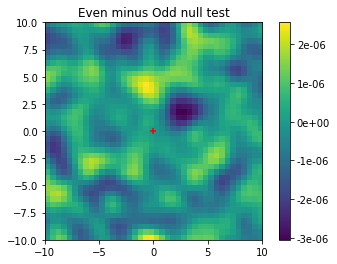

In [49]:
stack_even, stack_num_even = s18dStack(ra[0::2], dec[0::2], s18d)#, weight = True)
stack_odd, stack_num_odd = s18dStack(ra[1::2], dec[1::2], s18d)#, weight = True)

plot = plt.imshow(stack_even-stack_odd, extent = [-10,10,-10,10])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title('Even minus Odd null test')
plt.savefig("even_odd_null_no_weight.png")
plt.show()
plt.close()


# Jackknife Variance


In [10]:
yerr_jk = []
jks = {}

for i in range(bins):
    
    num_jk = 20
    
    jks['{}'.format(i)] = []
    
    cut = np.where((rich>perc[i]) & (rich <= perc[i+1]))[0]
    
    ra_cut = ra[cut]
    dec_cut = dec[cut]
    rich_cut = rich[cut]
    names_cut = names[cut]
    
    chunks = np.array_split(range(len(ra_cut)),num_jk)    

    for j in range(num_jk):
        
        ra_temp = np.delete(ra_cut, chunks[j])
        dec_temp = np.delete(dec_cut, chunks[j])
        rich_temp = np.delete(rich_cut, chunks[j])
        names_temp = np.delete(names_cut, chunks[j])
        
        #print(ra_temp)
        
        stack, stack_num = s18dStack(ra_temp, dec_temp, s18d)#, weight = True)
    
        jks['{}'.format(i)].append(stack)
        #stack_nums.append(stack_num)
        
        print(j)
        
pk.dump(stacks, open( "unweighted_jks.p", "wb" ))


Number in stack: 106
0
Number in stack: 106
1
Number in stack: 106
2
Number in stack: 106
3
Number in stack: 106
4
Number in stack: 106
5
Number in stack: 106
6
Number in stack: 106
7
Number in stack: 106
8
Number in stack: 106
9
Number in stack: 106
10
Number in stack: 106
11
Number in stack: 107
12
Number in stack: 107
13
Number in stack: 107
14
Number in stack: 107
15
Number in stack: 107
16
Number in stack: 107
17
Number in stack: 107
18
Number in stack: 107
19
Number in stack: 101
0
Number in stack: 101
1
Number in stack: 101
2
Number in stack: 101
3
Number in stack: 101
4
Number in stack: 101
5
Number in stack: 101
6
Number in stack: 102
7
Number in stack: 102
8
Number in stack: 102
9
Number in stack: 102
10
Number in stack: 102
11
Number in stack: 102
12
Number in stack: 102
13
Number in stack: 102
14
Number in stack: 102
15
Number in stack: 102
16
Number in stack: 102
17
Number in stack: 102
18
Number in stack: 102
19
Number in stack: 115
0
Number in stack: 115
1
Number in stac

Number in stack: 116
8
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 116
9
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.542

Number in stack: 78
12
Number in stack: 78
13
Number in stack: 78
14
Number in stack: 78
15
Number in stack: 78
16
Number in stack: 78
17
Number in stack: 78
18
Number in stack: 78
19
Number in stack: 84
0
Number in stack: 84
1
Number in stack: 84
2
Number in stack: 84
3
Number in stack: 84
4
Number in stack: 84
5
Number in stack: 84
6
Number in stack: 84
7
Number in stack: 84
8
Number in stack: 85
9
Number in stack: 85
10
Number in stack: 85
11
Number in stack: 85
12
Number in stack: 85
13
Number in stack: 85
14
Number in stack: 85
15
Number in stack: 85
16
Number in stack: 85
17
Number in stack: 85
18
Number in stack: 85
19
Number in stack: 113
0
Number in stack: 113
1
Number in stack: 113
2
Number in stack: 113
3
Number in stack: 113
4
Number in stack: 113
5
Number in stack: 113
6
Number in stack: 113
7
Number in stack: 113
8
Number in stack: 113
9
Number in stack: 113
10
Number in stack: 113
11
Number in stack: 113
12
Number in stack: 113
13
Number in stack: 113
14
Number in stack:

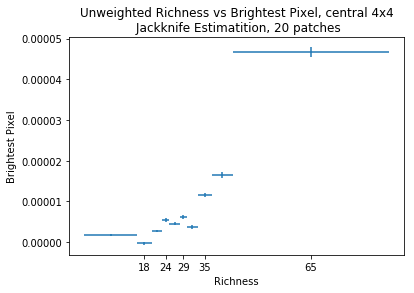

In [12]:
y = []
yerr_jk = []

for i in range(len(stacks)):
    straps = []
    y.append(np.amax(stacks[i][18:22, 18:22]))

    for j in range(len(jks['{}'.format(i)])):
        cur_stack = jks['{}'.format(i)][j]
        straps.append(np.amax(cur_stack[18:22, 18:22]))
    yerr_jk.append(np.sqrt(np.var(straps)))
   

x = []
xerr = []

for i in range(len(perc)-1):
    x.append((perc[i]+perc[i+1])/2)
    xerr.append((perc[i+1]-perc[i])/2)
plt.errorbar(x, y, xerr = xerr, yerr = yerr_jk, ls = 'none')
plt.xticks(x[1::2])
plt.title('Unweighted Richness vs Brightest Pixel, central 4x4\n Jackknife Estimatition, 20 patches')
plt.xlabel('Richness')
plt.ylabel('Brightest Pixel')
plt.savefig('jk_brightrich_unweighted.pdf')
plt.show()

In [57]:
t = QTable.read('/scratch/r/rbond/jorlo/AdvACT2.fits')

ra = t['RADeg']
dec = t['decDeg']
ra, dec = np.array(ra), np.array(dec)

path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_z_independent_matches.fits')
in_act = act[1].data['Name']

names = t['name']

print(in_act)

for name in in_act:
    if name not in names:
        print(name)

print('space')
for name in names:
    if 'J2321' in name:
        print(name)

['ACT-CL J0221.0+1755' 'ACT-CL J0248.4-0925' 'ACT-CL J1521.1+0451'
 'ACT-CL J1152.3+1652' 'ACT-CL J0023.9-0945' 'ACT-CL J1205.3-0245'
 'ACT-CL J2319.8-1856' 'ACT-CL J0212.2+0746' 'ACT-CL J2326.2+0030'
 'ACT-CL J0105.5+1323' 'ACT-CL J0448.4-1705' 'ACT-CL J1346.2-0142'
 'ACT-CL J2332.6-0014' 'ACT-CL J0125.3-0802' 'ACT-CL J1151.2+1656'
 'ACT-CL J0028.1-1005' 'ACT-CL J0308.1-2915' 'ACT-CL J2231.9+1131'
 'ACT-CL J1454.6+0628' 'ACT-CL J0131.9+0329' 'ACT-CL J0256.5+0006'
 'ACT-CL J0048.4+1757' 'ACT-CL J1455.5+0439' 'ACT-CL J0303.6+1857'
 'ACT-CL J1418.2+0723' 'ACT-CL J1149.4+0921' 'ACT-CL J1208.3+0501'
 'ACT-CL J1014.1+0038' 'ACT-CL J0101.7+0030' 'ACT-CL J2121.8+0040'
 'ACT-CL J1536.5+0954' 'ACT-CL J0300.2+0125' 'ACT-CL J1048.7+0743'
 'ACT-CL J1354.8+1329' 'ACT-CL J1008.7+1147' 'ACT-CL J1205.0+1525'
 'ACT-CL J2235.0+1321' 'ACT-CL J0239.6-1036' 'ACT-CL J0102.6+0201'
 'ACT-CL J0934.4+1751' 'ACT-CL J2316.2+0920' 'ACT-CL J0103.7+0119'
 'ACT-CL J1620.1+1340' 'ACT-CL J1110.2-0030' 'ACT-CL J1139.3+0

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b7db49e0940>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b7db49e0da0>]

chararray(['ACT-CL J0019.0-0000', 'ACT-CL J0019.8+0210',
           'ACT-CL J0023.9-0945', 'ACT-CL J0028.1-1005',
           'ACT-CL J0048.4+1757', 'ACT-CL J0101.7+0030',
           'ACT-CL J0102.6+0201', 'ACT-CL J0105.5+1323',
           'ACT-CL J0105.8-1839', 'ACT-CL J0120.7-0305',
           'ACT-CL J0125.3-0802', 'ACT-CL J0129.2-1641',
           'ACT-CL J0131.9+0329', 'ACT-CL J0208.1-0935',
           'ACT-CL J0212.2+0746', 'ACT-CL J0221.0+1755',
           'ACT-CL J0234.5-0107', 'ACT-CL J0239.6-1036',
           'ACT-CL J0248.4-0925', 'ACT-CL J0256.5+0006',
           'ACT-CL J0300.2+0125', 'ACT-CL J0303.6+1857',
           'ACT-CL J0308.1-2915', 'ACT-CL J0353.3+0832',
           'ACT-CL J0448.4-1705', 'ACT-CL J0934.4+1751',
           'ACT-CL J1008.7+1147', 'ACT-CL J1014.1+0038',
           'ACT-CL J1029.9+0016', 'ACT-CL J1048.7+0743',
           'ACT-CL J1053.2+1052', 'ACT-CL J1110.2-0030',
           'ACT-CL J1139.3+0154', 'ACT-CL J1142.1+1345',
           'ACT-CL J1142.7+1527